<a href="https://colab.research.google.com/github/jahelsantiago/tensorflow_tutorial/blob/master/cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from tensorflow.keras.models import Sequential

descargamos los datos

In [ ]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"    

--2020-08-08 04:38:59--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.35.76.84, 2600:1407:d800:29f::e59, 2600:1407:d800:29d::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.35.76.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   115MB/s    in 7.7s    

2020-08-08 04:39:07 (102 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



#### descomprimimps el archivo zip

In [ ]:
zip_path = "/tmp/cats-and-dogs.zip"
zip = zipfile.ZipFile(zip_path,"r")
zip.extractall("/tmp")
zip.close()

In [ ]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


#### creamos los directorios para almacenar los train y test

In [ ]:
try:
  os.mkdir("/tmp/cats-v-dogs/")

  os.mkdir("/tmp/cats-v-dogs/training")
  os.mkdir("/tmp/cats-v-dogs/training/cats")
  os.mkdir("/tmp/cats-v-dogs/training/dogs")

  os.mkdir("/tmp/cats-v-dogs/testing")
  os.mkdir("/tmp/cats-v-dogs/testing/cats")
  os.mkdir("/tmp/cats-v-dogs/testing/dogs")
except OSError:
    print("error al crear carpetas")
    pass



dividimos el train y test set de manera aleatoria

In [ ]:
def transfer_data(SOURCE, DESTINY, DATA):
  for path in DATA:
    if (os.path.getsize(os.path.join(SOURCE,path)) != 0):      
        copyfile(os.path.join(SOURCE,path), os.path.join(DESTINY,path))
  

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  source_data = os.listdir(SOURCE)
  source_data = random.sample(source_data, len(source_data))

  train_data = source_data[:int(len(source_data)*SPLIT_SIZE)]
  test_data = source_data[int(len(source_data)*SPLIT_SIZE):]
  
  transfer_data(SOURCE, TRAINING, train_data)
  transfer_data(SOURCE, TESTING, test_data)

In [ ]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [ ]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11249
11249
1251
1251


#### borrar un directorio por si la embarramos

In [ ]:
from shutil import rmtree
#rmtree("/tmp/cats-v-dogs") por si fallo algo borra la carpeta

#### creamos el modelo

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
model = Sequential([
                    Conv2D(16,(3,3),input_shape=(300,300,3),activation="relu"),
                    MaxPool2D(2,2),
                    Conv2D(32,(3,3), activation="relu"),
                    MaxPool2D((2,2),2),
                    Conv2D(64,(3,3), activation="relu"),
                    MaxPool2D((2,2),2),
                    Flatten(),
                    Dense(128, activation="relu"),
                    Dense(1,activation="sigmoid")                                  
])

model.compile(optimizer="adam", loss ="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 78400)             0

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1./255)
train = data_gen.flow_from_directory(
    "/tmp/cats-v-dogs/training",
    target_size = (300,300),
    batch_size = 64,
    class_mode = "binary"
)

test = data_gen.flow_from_directory(
    "/tmp/cats-v-dogs/testing",
    target_size = (300,300),
    batch_size = 64,
    class_mode = "binary"
)

Found 22496 images belonging to 2 classes.
Found 2502 images belonging to 2 classes.


In [ ]:
history = model.fit(train,epochs=5,validation_data=test, verbose=1)

Epoch 1/5
 66/352 [====>.........................] - ETA: 1:17 - loss: 0.4345 - accuracy: 0.7933

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

352/352 [==============================] - 105s 298ms/step - loss: 0.4271 - accuracy: 0.8016 - val_loss: 0.4554 - val_accuracy: 0.7882
Epoch 2/5
352/352 [==============================] - 105s 297ms/step - loss: 0.3404 - accuracy: 0.8514 - val_loss: 0.4484 - val_accuracy: 0.8026
Epoch 3/5
352/352 [==============================] - 107s 303ms/step - loss: 0.2379 - accuracy: 0.9015 - val_loss: 0.4689 - val_accuracy: 0.8161
Epoch 4/5
352/352 [==============================] - 104s 295ms/step - loss: 0.1311 - accuracy: 0.9515 - val_loss: 0.6060 - val_accuracy: 0.7990
Epoch 5/5
352/352 [==============================] - 103s 293ms/step - loss: 0.0569 - accuracy: 0.9808 - val_loss: 0.7957 - val_accuracy: 0.8038


#### visualizar el desempeño

Text(0.5, 1.0, 'Training and validation loss')

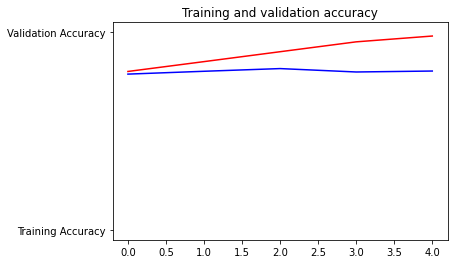

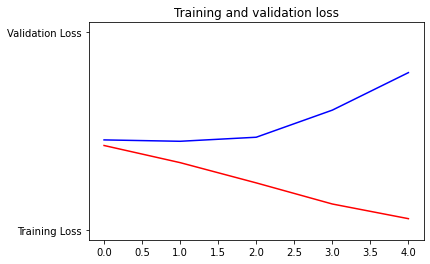

In [ ]:
%matplotlib inline 

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

#### corremos el modelo con una imagen cualquiera

In [ ]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(# YOUR CODE HERE))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")